## Set Up Environment

In [1]:
!export ARCHFLAGS="-arch arm64"

In [2]:
!python setup.py clean --all
!python 'setup.py' install
!python 'setup.py' build

running clean
removing 'build/temp.macosx-10.9-x86_64-cpython-39' (and everything under it)
removing 'build/lib.macosx-10.9-x86_64-cpython-39' (and everything under it)
removing 'build/bdist.macosx-10.9-x86_64' (and everything under it)
'build/scripts-3.9' does not exist -- can't clean it
running install
/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/setuptools/_d

In [3]:
!find build/ -name "*.so"
''' For macOS, this should return the following files: 
      build//lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so
      build//lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so
    If the above values are not a part of the result, switch from arm to x86 architecture
'''

build//bdist.macosx-10.9-x86_64/egg/ddalpha.cpython-39-darwin.so
build//bdist.macosx-10.9-x86_64/egg/depth_wrapper.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-cpython-39/ddalpha.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-cpython-39/depth_wrapper.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so


' For macOS, this should return the following files: \n      build//lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so\n      build//lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so\n    If the above values are not a part of the result, switch from arm to x86 architecture\n'

In [4]:
import math
import numpy as np
import pandas as pd
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from depth.multivariate import *
from numpy.random import RandomState
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Generate Toy 2D Dataset
We use the multivariate_normal function in numpy, using the speficiations given in the anomaly detection paper.

In [5]:
mean1 = (1, 1)
mean2 = (-3.181, -0.222)
cov1 = [[1, 1], [1, 2]]
cov2 = [[i / 36 for i in j] for j in cov1]

(100,) (100, 2)


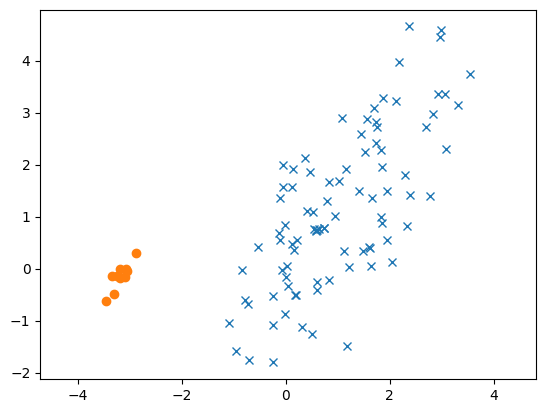

In [6]:
# use fixed random seed for reproducable results
rng = np.random.default_rng(322180440709489274700185804004290683059)
x, y = rng.multivariate_normal(mean1, cov1, 90).T
anom_x, anom_y = rng.multivariate_normal(mean2, cov2, 10).T

# Combine x and anom_x
combined_x = np.concatenate([x, anom_x])
combined_y = np.concatenate([y, anom_y])

# compute combined dataset
combined_data = np.column_stack((combined_x, combined_y))
print(combined_x.shape, combined_data.shape) # should be (100, ) and (100, 2)

# Plot the combined dataset
plt.plot(x, y, 'x')
plt.plot(anom_x, anom_y, 'o')
plt.axis('equal')
plt.show()

## Compute Data Depth using different definitions

In [7]:
# compute projection depth for each point in the combined dataset
projection_depths = projection(combined_x, combined_data, NRandom=1000)
##TODO: Figure out why this only returns a single value
projection_depths
print(combined_x.shape, combined_data.shape)
print(type(combined_x), type(combined_data))

(100,) (100, 2)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
# compute different depths for each point in the combined dataset
halfspace_depths = halfspace(combined_x, combined_data)
mahalanobis_depths = mahalanobis(combined_x, combined_data)
simplicial_depths = simplicial(combined_x, combined_data)
convex_hull_depths = qhpeeling(combined_x, combined_data)
halfspace_depths

array([0.15, 0.1 , 0.23, 0.  , 0.1 , 0.16, 0.  , 0.06, 0.  , 0.1 , 0.02,
       0.33, 0.  , 0.09, 0.01, 0.  , 0.2 , 0.07, 0.04, 0.11, 0.09, 0.1 ,
       0.02, 0.08, 0.29, 0.11, 0.15, 0.  , 0.09, 0.12, 0.  , 0.17, 0.11,
       0.26, 0.25, 0.22, 0.07, 0.4 , 0.1 , 0.04, 0.14, 0.38, 0.03, 0.06,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.23, 0.23, 0.23, 0.23,
       0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23,
       0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23,
       0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23,
       0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23,
       0.23])

## Plot depth contour plots for each definition

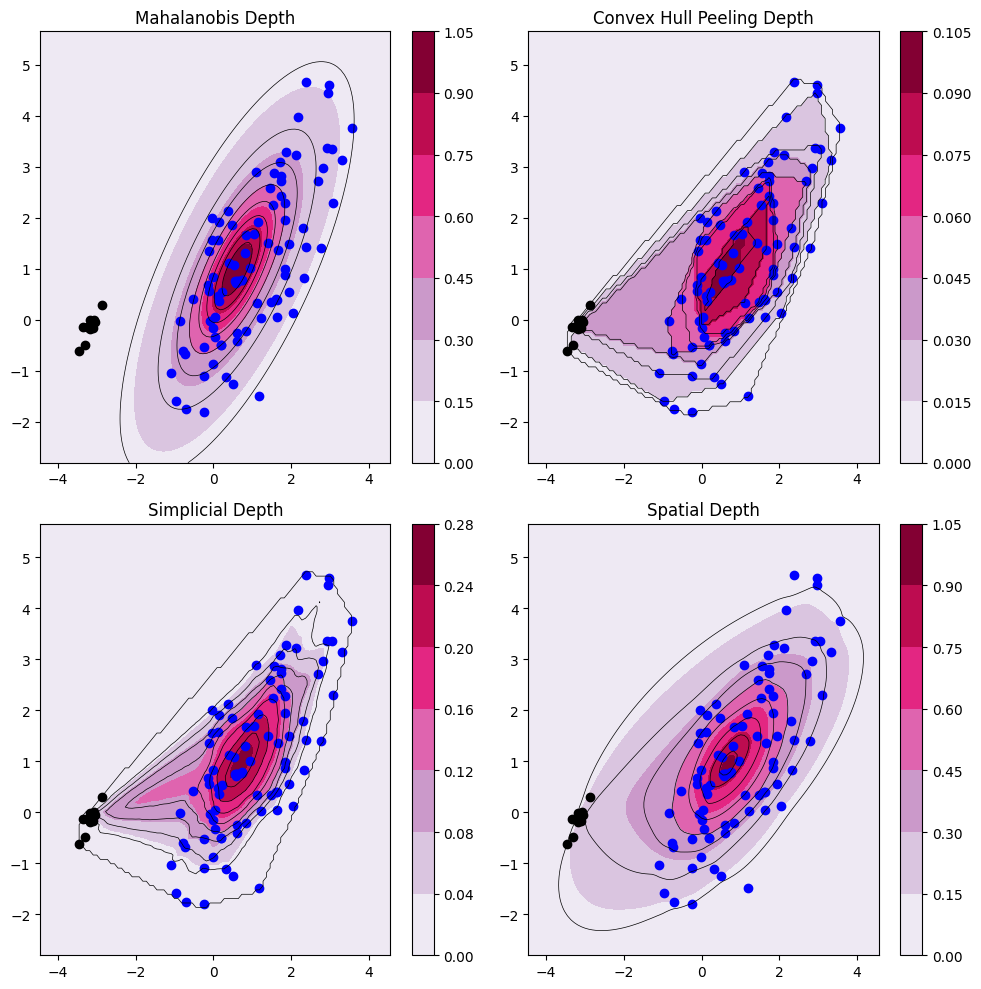

In [9]:
# Function to plot depth contours
def plot_depth_contours(ax, depth_function, title):
    # Create grid for plotting
    grid_x, grid_y = np.mgrid[combined_x.min()-1:combined_x.max()+1:100j, combined_y.min()-1:combined_y.max()+1:100j]
    grid = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    
    # Compute depth on the grid
    grid_depths = depth_function(grid, combined_data)
    grid_depths = grid_depths.reshape(grid_x.shape)
    
    # Plot depth contours
    lw = [0.5 for i in range(10)]
    contour = ax.contourf(grid_x, grid_y, grid_depths, cmap="PuRd")
    ax.contour(grid_x, grid_y, grid_depths, colors='k', levels=np.linspace(grid_depths.min(), grid_depths.max(), 10), linewidths=0.5)
    ax.scatter(x, y, c='blue', label='Data points')
    ax.scatter(anom_x, anom_y, c='black', label='Data points')
    
    # Add a color bar
    fig.colorbar(contour, ax=ax, orientation='vertical')

    ax.set_title(title)
    # ax.axis('equal')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_depth_contours(axs[0, 0], mahalanobis, "Mahalanobis Depth")
plot_depth_contours(axs[0, 1], qhpeeling, "Convex Hull Peeling Depth")
plot_depth_contours(axs[1, 0], simplicial, "Simplicial Depth")
plot_depth_contours(axs[1, 1], spatial, "Spatial Depth")


plt.tight_layout()
plt.show()

## Generate Toy 3D Datasets

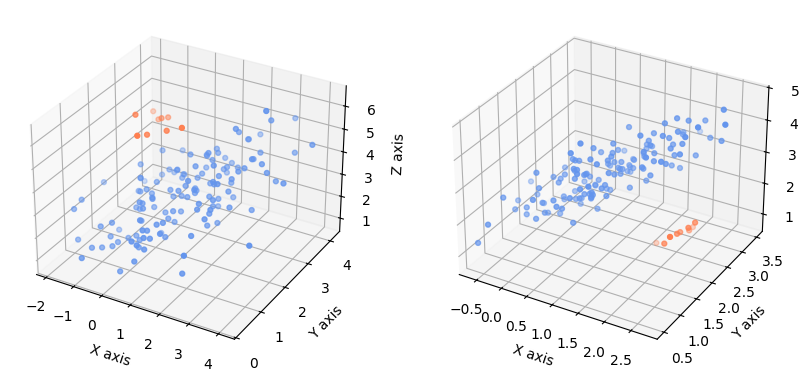

In [10]:
def generateToy3D(true, anomaly, mean=(1, 2, 3), anom_mean=(0, 2, 6), sparsity=5, random_state=666888999) :
    # change random state for a different example
    prng = RandomState(random_state)

    # modify these values to change where the data is centered
    mean = mean
    anom_mean = anom_mean

    # random matrix for covariance
    random_matrix = prng.rand(3, 3)
    # ensuring that the matrix is symmetric positive-semidefinite
    cov = np.dot(random_matrix, random_matrix.T)
    cov += np.eye(3) * 1e-6

    # modify these values to control the spread of the anmalies
    # smaller values = sparser anomalies
    anom_cov = cov / sparsity

    x, y, z = rng.multivariate_normal(mean, cov, size=true).T
    anom_x, anom_y, anom_z = rng.multivariate_normal(anom_mean, anom_cov, size=anomaly).T
    
    # Combine all true and anomaly values 
    # (separately in case we need to extract this later)
    combined_x = np.concatenate([x, anom_x])
    combined_y = np.concatenate([y, anom_y])
    combined_z = np.concatenate([z, anom_z])

    # compute combined dataset
    combined_data = np.column_stack((combined_x, combined_y, combined_z))
    # print(combined_x.shape, combined_data.shape) # for testing
    
    return combined_data

def plot3dScatter(ax, combined_data, true) :
    # divide data into dimensions
    x, y, z = combined_data[:, 0], combined_data[:, 1], combined_data[:, 2]
    
    # we assume that the dataset is a combination of  
    # true points followed by the anomalies
    ax.scatter(x[:true], y[:true], z[:true], color='cornflowerblue', s=[50], marker='.')
    ax.scatter(x[true+1:], y[true+1:], z[true+1:], color='coral', s=[50], marker='.')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

# creating a figure with two subplots
# can be modified to plot any number of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10), subplot_kw=dict(projection='3d'))

combined_data = generateToy3D(140, 10)
plot3dScatter(axs[0], combined_data, 140)

combined_data = generateToy3D(140, 10, anom_mean = (2, 2.5, 1), sparsity=16, random_state=10000202)
plot3dScatter(axs[1], combined_data, 140)

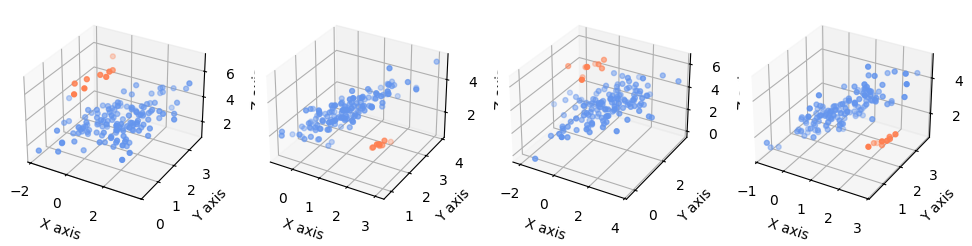

In [11]:
# Example with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 12), subplot_kw=dict(projection='3d'))

combined_data = generateToy3D(140, 10)
plot3dScatter(axs[0], combined_data, 140)

combined_data = generateToy3D(140, 10, anom_mean = (2, 2.5, 1), sparsity=16, random_state=10000202)
plot3dScatter(axs[1], combined_data, 140)

combined_data = generateToy3D(140, 10)
plot3dScatter(axs[2], combined_data, 140)

combined_data = generateToy3D(140, 10, anom_mean = (2, 2.5, 1), sparsity=16, random_state=10000202)
plot3dScatter(axs[3], combined_data, 140)

In [12]:
# Function to split dataset into n equal parts based on data depths
def split_dataset(df, column_name, n) :
    # Sort the dataframe based on the column
    df_sorted = df.sort_values(by=column_name)
    
    # calculating split points
    total_rows = df_sorted.shape[0]
    split_points = [int(i * total_rows / n) for i in range(1, n)]
    
    # splitting the dataframe into n parts
    parts = []
    start_idx = 0
    for split_point in split_points:
        part = df_sorted.iloc[start_idx:split_point]
        # cleaning and turning it back to a numpy array
        part = part.drop(columns=['depth'])
        parts.append(part.to_numpy())
        start_idx = split_point
    
    # adding the last part
    part = df_sorted.iloc[start_idx:].drop(columns=['depth'])
    parts.append(part.to_numpy())
    
    return parts

In [13]:
# Using L2 for this example since it shows the 
# most variability in data depth values
depths = L2(combined_data[:,2], combined_data)
df = pd.DataFrame(combined_data, columns=['x', 'y', 'z'])
df['depth'] = depths
df = df.sort_values(by='depth')
print(df.head())
print(df.tail())

# Calculate statistics
min_depth = df['depth'].min()
max_depth = df['depth'].max()
depth_range = max_depth - min_depth
mean_depth = df['depth'].mean()
std_depth = df['depth'].std()

print(f"Min Depth: {min_depth}")
print(f"Max Depth: {max_depth}")
print(f"Depth Range: {depth_range}")
print(f"Mean Depth: {mean_depth}")
print(f"Std Depth: {std_depth}")

# Set tolerance to be 1 standard deviation (adjustable)
tolerance = std_depth
half_tolerance = tolerance/2
third_tol = tolerance/3

            x         y         z     depth
105  1.517366  2.547957  5.037325  0.145534
138  2.627669  2.908534  4.834356  0.152882
121  2.181759  3.018077  4.679431  0.158844
67   1.720331  2.602686  4.579269  0.162860
16   2.781352  2.707547  4.490804  0.166510
           x         y         z     depth
39  1.059652  2.241474  2.561423  0.236962
32  0.224139  2.041616  2.509260  0.236967
57  0.824926  2.088595  2.547074  0.236981
47  0.960225  2.140200  2.524723  0.236984
9   0.942009  2.120125  2.535321  0.236987
Min Depth: 0.14553388228457323
Max Depth: 0.23698673445003512
Depth Range: 0.0914528521654619
Mean Depth: 0.21795922032581713
Std Depth: 0.02150771940614966


In [14]:
def split_dataframe_by_tolerance(df, column_name, tolerance, min_points=4):
    # Sort the dataframe based on the column
    df_sorted = df.sort_values(by=column_name).reset_index(drop=True)
    bins = []
    current_bin = []
    start_value = df_sorted[column_name].iloc[0]
    
    for idx, row in df_sorted.iterrows():
        if abs(row[column_name] - start_value) <= tolerance:
            current_bin.append(row)
        else:
            if len(current_bin) < min_points:
                # If the current bin has less than min_points, merge it with the previous bin
                if bins:
                    bins[-1] = pd.concat([bins[-1], pd.DataFrame(current_bin)])
                else:
                    bins.append(pd.DataFrame(current_bin))
            else:
                bins.append(pd.DataFrame(current_bin))
            current_bin = [row]
            start_value = row[column_name]
    
    if current_bin:
        if len(current_bin) < min_points and bins:
            bins[-1] = pd.concat([bins[-1], pd.DataFrame(current_bin)])
        else:
            bins.append(pd.DataFrame(current_bin))
    
    return bins

In [15]:
import matplotlib.colors as mcolors
# Function to calculate the distance of a point from the camera perspective
def distance_from_camera(p, camera_position):
    return np.linalg.norm(p - camera_position)

# Function to plot a convex hull given an np array of points
#     view is the position of the viewport "camera" in a 3D plot 
#     for more information refer to https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html
def plot_convex_hull(ax, points, all, view=[30, 45, 15]) :
    points = points.to_numpy()[:, :3]
    # Compute the convex hull and use delaunay triangulation to see if points are inside or outside hull
    hull = ConvexHull(points)
    # this is now redundant since we plot all the points in each instance
    # hull_delaunay = Delaunay(points[hull.vertices]) 

    # Camera position
    #   This value is just set to represent the camera position that is the default for 3D plots
    #   it would need to be changed manually if you alter the plot rendering angle.
    camera_position = np.array([1, 0, 1])

    # max_distance = distance_from_camera(np.array([0, 0, 0]))
    # max_distance = distance_from_camera(points, camera_position)
    distances = np.array([distance_from_camera(point, camera_position) for point in points])
    min_distance = distances.min()
    max_distance = distances.max()

    # Plot construction
    ax.view_init(elev=view[0], azim=view[1], roll=view[2])

    # Plotting the convex hull with color based on distance from camera point
    for simplex in hull.simplices:
        s = np.append(simplex, simplex[0])
        poly = Poly3DCollection([points[s]])

        # Calculate centroid of the facet
        centroid = np.mean(points[simplex], axis=0)

        # Old code : replace when processing large # of points
        # color_intensity = distance_from_camera(centroid, camera_position) / max_distance
        # poly.set_facecolor((0, 0, 1-color_intensity, 0.5))
        
        # Calculate the distance of the centroid from the camera
        distance = distance_from_camera(centroid, camera_position)
        color_intensity = (distance - min_distance) / (max_distance - min_distance)

        # Map color_intensity to hue in HSV space, then convert to RGB
        hue = 1 - color_intensity  # Hue goes from 0 to 1
        saturation = 0.5  # Pastel colors have low saturation
        value = 1  # High value for light colors
        rgb_color = mcolors.hsv_to_rgb((hue, saturation, value))
        
        # Set color based on distance for pastel colors
        poly.set_facecolor((*rgb_color, 0.8)) 
        
        ax.add_collection3d(poly)

    # Plotting the points that are not inside the convex hull
    for point in all.to_numpy()[:, :3]:
        ax.scatter(point[0], point[1], point[2], color='cornflowerblue', marker='.')

    # Setting labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

In [16]:

# Function to plot the progession of convex hull according to data depth
# given a dataset of points and their depths
def convex_hull_progression(df, tolerance, rows=2, fig_size=(8, 8), view=[30, 120, 60]) :
    # split dataset into n parts
    # parts = split_dataset(df, 'depth', n)[::-1]
    parts = split_dataframe_by_tolerance(df, 'depth', tolerance)[::-1]

    # find number of columns
    index, l = 0, len(parts)
    columns = math.ceil(l/rows)

    # creating figure according to given specifications
    fig, axs = plt.subplots(rows, columns, figsize=fig_size, subplot_kw=dict(projection='3d'))

    current_points = parts[0]
    # We need a minimum of 4 points to construct a convex hull
    if current_points.shape[0] < 4 : 
        current_points = pd.concat([parts[index], current_points])
        index += 1

    # add convex hull for each part to the figure
    for i in range(rows) : 
        for j in range(columns) : 
            if index < l :
                print(f"Plotting part {index + 1}/{l}")
                current_points = pd.concat([parts[index], current_points])
                plot_convex_hull(axs[i, j], current_points, df, view)
                index += 1
            else : 
                axs[i, j].axis('off')
    plt.show()

Plotting part 1/5
Plotting part 2/5
Plotting part 3/5
Plotting part 4/5
Plotting part 5/5


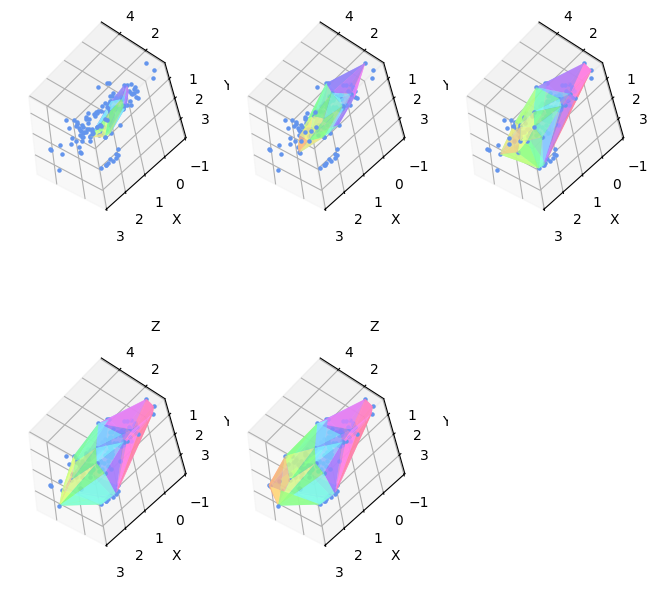

In [17]:
convex_hull_progression(df, tolerance) # default 

Plotting part 1/10
Plotting part 2/10
Plotting part 3/10
Plotting part 4/10
Plotting part 5/10
Plotting part 6/10
Plotting part 7/10
Plotting part 8/10
Plotting part 9/10
Plotting part 10/10


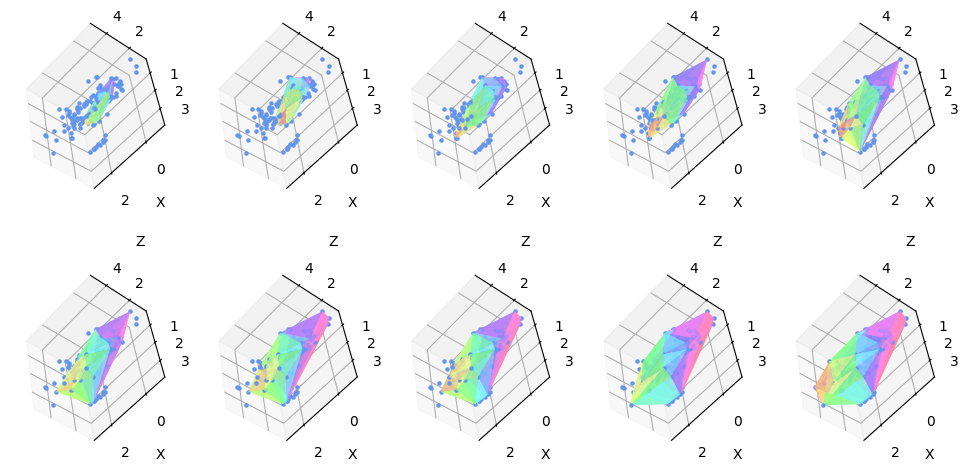

In [18]:
# try these out : 
# convex_hull_progression(df, tolerance, view=[30, 45, 120])
# convex_hull_progression(df, half_tolerance, rows=2, fig_size=(12, 8)) 
convex_hull_progression(df, third_tol, rows=2, fig_size=(12, 6))